In [349]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import zscore
import numpy as np
import pylab as pl
from matplotlib import collections  as mc
from mpl_toolkits.mplot3d import Axes3D
import pickle
import codecs

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
from sklearn import linear_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [270]:
def cross_validation(lin_model, set_of_alphas, set_of_L1, X_t, y_t=y_train):
    # Sratified cross-validation with 8 folds 
    
    # @params
    # lin_model: This is a value between "Ridge", "Lasso" or "Elastic Net". It makes the function able to understand which is the type of model that has to be optimized.
    # set_of_alphas: This is the alpha set in which we want to search for the optimal one.
    # set_of_L1: This is the L1 set in which we want to search for the optimal one.
    # X_t: This is the training set (here it is the 85% of the entire dataset). This set will be splitted in n_folds splits and the procedure of crossvalidation will be
    #      carried on periodically on these splits. It is encoded with "minmaxscale".
    # y_t: This is the labels set associated with X_t data. It is encoded with "log1p + zscore normalization"
     
    print "Cross validaton for ", lin_model
    n_folds=8
    skf = StratifiedKFold(cv_split_flag, n_folds=n_folds)
    set_of_params = set_of_alphas if set_of_L1 is None else [(x,y) for x in set_of_l1_ratios for y in set_of_alpha]
    r2 = np.zeros(len(set_of_params))

    for cv_train_index, cv_val_index in skf:
        X_cv_train, X_cv_val = X_t[cv_train_index], X_t[cv_val_index]
        # For each fold we define a y_cv_val set of labels that are the not normalized labels associated with the X_cv_val dataset.
        y_cv_train, y_cv_val = y_t[cv_train_index], reverse_normalization(y_t[cv_val_index])

        for param_idx, param in enumerate(set_of_params):
            # Basing on the value of the "lin_model" param we allocate the corresponding model.
            if lin_model == 'Ridge':                
                lin_cv_reg = linear_model.Ridge(alpha = param)
            elif lin_model == 'Lasso':
                lin_cv_reg = linear_model.Lasso(alpha = param)
            elif lin_model == 'EN':
                lin_cv_reg = linear_model.ElasticNet(alpha = param[1], l1_ratio = param[0])
            # Nel fit method X_cv_train è in scala "minmaxscale" e y_cv_train è in scala "log1p + zscore"
            # ==> Dato che il modello viene fittato usando y_cv_train che è scalato usando "log1p + zscore", le predizioni vengono fatte in scala di y_cv_train, 
            #     quindi lin_cv_reg.predict(X_cv_val) restituisce una predizione in scala "log + zscore".
            # - MOTIVO: normalizzando il target in questo modo il modello riesce a interpretare meglio la diffrenza tra i diversi valori del target.
            #           Quindi valori diversi del target vengono resi un po più diversi di quanto sono in modo tale da aiutare il modello ad apprezzarne la differenza.
            lin_cv_reg.fit(X_cv_train, y_cv_train)
            # Dato che la predizione è tradotta in grammi e viene confrontata con un set di valori in grammi l'errore è in grammi e quindi è reale.
            yp_cv = reverse_normalization(lin_cv_reg.predict(X_cv_val))
            rss_cv = sum((yp_cv - y_cv_val)**2)
            tss_cv = sum((y_cv_val-y_cv_val.mean())**2)
            r2_cv = 1 - rss_cv/tss_cv
            r2[param_idx] = r2[param_idx] + r2_cv

    r2 = r2 / n_folds
    
    if set_of_L1 is None:
        # Plot results
        print "BEST ALPHA (R2) = ", set_of_alphas[np.argmax(r2)], " R2: ", np.amax(r2)
        plt.scatter(set_of_params, r2)
        ax = plt.axes()
        ax.relim()
        ax.autoscale_view()
        plt.plot(set_of_params, r2)
    else:
        # Plot results
        print "BEST ALPHA (R2) = ", set_of_params[np.argmax(r2)][1], " R2: ", np.amax(r2)
        print "BEST L1 (R2) = ", set_of_params[np.argmax(r2)][0], " R2: ", np.amax(r2)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        Y = map(lambda x: x[0], set_of_params)
        X = map(lambda x: x[1], set_of_params)
        for i in np.arange(len(X)):
            ax.scatter(X[i], Y[i], r2[i], color = "r")
            ax.plot_surface(X[i], Y[i], r2[i], color = "b")
        ax.set_xlabel('alpha')
        ax.set_ylabel('L1')
        ax.set_zlabel('R2')
        plt.show()
    return set_of_params[np.argmax(r2)]

In [333]:
def score_model(lin_model, X_tr, Y_tr, X_ts, Y_ts_not_norm, best_alpha, best_L1):
    # @params
    # lin_model: the string representing the model to be scored
    # X_tr: The training set to train the model
    # 
    print "BEST ALPHA (R2) = " + str(best_alpha)
    if best_L1 is not None:
        print "BEST L1 (R2) = " + str(best_L1)
    if lin_model == 'Ridge':                
        lin_reg = linear_model.Ridge(alpha = best_alpha)
    elif lin_model == 'Lasso':
        lin_reg = linear_model.Lasso(alpha = best_alpha)
    elif lin_model == 'EN':
        lin_reg = linear_model.ElasticNet(alpha = best_alpha, l1_ratio = best_L1)
    lin_reg.fit(X_tr, Y_tr)
    yp = reverse_normalization(lin_reg.predict(X_ts))
    rss = sum((yp - Y_ts_not_norm) ** 2)
    tss = sum((Y_ts_not_norm - Y_ts_not_norm.mean())**2)
    r2 = 1 - rss / tss

    print "R2 = " +str(r2)

    plt.scatter(np.arange(0, len(Y_ts_not_norm)), yp, color='b')
    plt.scatter(np.arange(0, len(Y_ts_not_norm)), Y_ts_not_norm, color='r')

    lines = []
    ax = plt.axes()

    for i in range(yp.shape[0]):
        lines.append([(i, yp[i]), (i, Y_ts_not_norm[i])])

    lc = mc.LineCollection(lines, colors="g", linewidths=1)

    ax.add_collection(lc)
    ax.autoscale()
    ax.margins(0.1)
    plt.grid(True)

    plt.show()
    return lin_reg

In [350]:
def export_model(model, filename):
    with open(filename + '.pkl','wb') as out_file:
            s = codecs.encode(pickle.dumps(model), "base64").decode()
            out_file.write(s)
    put_object_storage_file_with_credentials_a860223228054eadb78455bad5266913('ITTProject', filename + '.pkl')

In [ ]:
# The code was removed by DSX for sharing.

In [345]:
def put_object_storage_file_with_credentials_a860223228054eadb78455bad5266913(container, filename):  
    f = open(filename,'r')
    file_data = f.read()
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': 'member_c31eef4c6875a326d7c2cb16984a5e02d9dace51','domain': {'id': 'e4c3685617404e40b0afb0d280e5d678'},
            'password': 'b31qd?[3APH3&].5'}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', container, '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = file_data )
    print resp2

In [58]:
df_data_1["Usura_mat_g"] = np.log1p(df_data_1["Usura_mat_g"])/10
target_mean = df_data_1["Usura_mat_g"].mean()
target_std = df_data_1["Usura_mat_g"].std()
df_data_1['Usura_mat_g'] = (df_data_1['Usura_mat_g'] - target_mean)/target_std
print "Data normalized: "
df_data_1.head()

Data normalized: 


,Usura_mat_g
0,0.560892
1,0.252558
2,-1.033143
3,-0.947414
4,-0.201524


In [49]:
def reverse_normalization(y_data):
    return np.exp(10*(y_data*target_std + target_mean)) - 1

In [59]:
print "Normalized data details: "
df_data_1.describe()

Normalized data details: 


,Usura_mat_g
count,6.510000e+02
mean,1.309756e-16
std,1.000000e+00
min,-1.658444e+00
25%,-7.323587e-01
50%,-1.808411e-01
75%,4.755100e-01
max,5.127817e+00


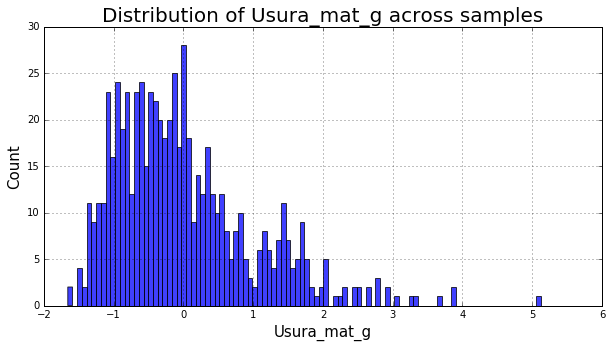

In [60]:
x = df_data_1["Usura_mat_g"].values

plt.hist(x, 100, facecolor='blue', alpha=0.75)

plt.title('Distribution of Usura_mat_g across samples', fontsize=20)
plt.xlabel('Usura_mat_g', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(True)

plt.show()

In [61]:
df_data_2 = df_data_2.drop("Usura_mat_g", 1)
df_data_2["flag"] = df_data_1["Usura_mat_g"].values < df_data_1["Usura_mat_g"].mean()


y = df_data_1["Usura_mat_g"].values

holdout_split_flag = df_data_2["flag"].values

#df_data_2 = df_data_1.drop("flag", 1)

X = df_data_2.values
# print df_data_1.corr()

print X.shape
print y.shape

(651, 243)
(651,)


In [62]:
from sklearn.cross_validation import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(holdout_split_flag, 1, test_size=.15, random_state=0)
test_index_set = set()

for train_index, test_index in sss:
    #print "TRAIN indices:", train_index, ", TEST indices:", test_index 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    test_index_set = test_index
    
    print "Train shape: " + str(X_train.shape)
    print "Test shape: " + str(X_test.shape)
    
target_not_normalized = df_not_as_loaded["Usura_mat_g"].values[test_index_set]

Train shape: (553, 243)
Test shape: (98, 243)


In [63]:
df_X_train = pd.DataFrame(data= X_train, columns=df_data_2.columns)
df_X_train_f = df_X_train.drop("flag", 1)
df_X_train_f = df_X_train_f.drop("Material", 1)
cv_split_flag = df_X_train["flag"].values
print (df_X_train.shape)
print (df_X_train_f.shape) # training set finale

df_X_test = pd.DataFrame(data= X_test, columns=df_data_2.columns)
df_X_test_f = df_X_test.drop("flag", 1)
df_X_test_f = df_X_test_f.drop("Material", 1)
print (df_X_test.shape)
print (df_X_test_f.shape) # test set finale

X_train = df_X_train_f.values
X_test = df_X_test_f.values

(553, 243)
(553, 241)
(98, 243)
(98, 241)


## Cross validation

Cross validaton for  Ridge
BEST ALPHA (R2) =  0.35  R2:  0.617116161852


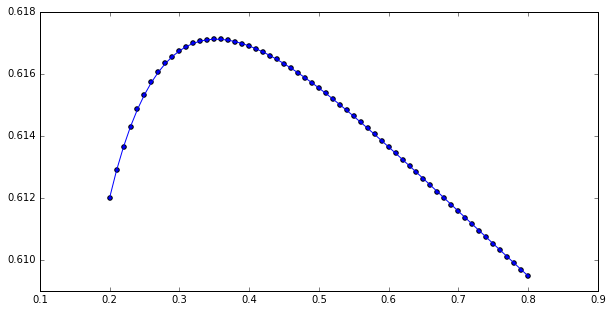

In [346]:
from sklearn.cross_validation import StratifiedKFold
set_of_alphas = np.arange(0.2, 0.8, step=0.01)
best_alpha_ridge = cross_validation('Ridge', set_of_alphas, None, X_train, y_train)

BEST ALPHA (R2) = 0.35
R2 = 0.644014842261


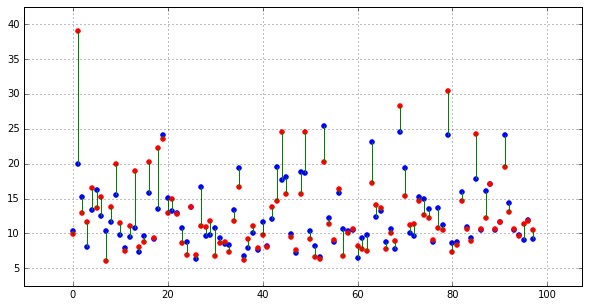

<Response [201]>


In [351]:
model = score_model('Ridge', X_train, y_train, X_test, target_not_normalized, best_alpha_ridge, None)
export_model(model, 'Ridge')

Cross validaton for  Lasso
BEST ALPHA (R2) =  0.0007  R2:  0.591420365433


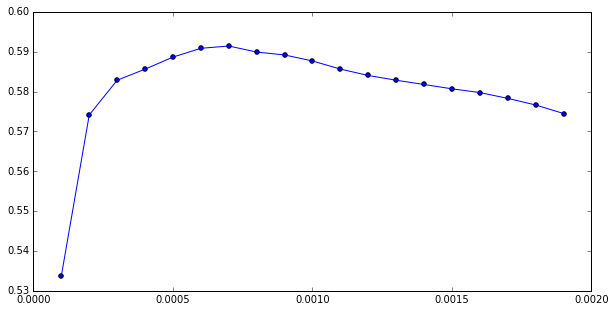

In [272]:
from sklearn.cross_validation import StratifiedKFold
set_of_alphas = np.arange(0.0001, 0.002, step=0.0001)
best_alpha_lasso = cross_validation('Lasso', set_of_alphas, None, X_train, y_train)

BEST ALPHA (R2) = 0.0007
R2 = 0.673172917568


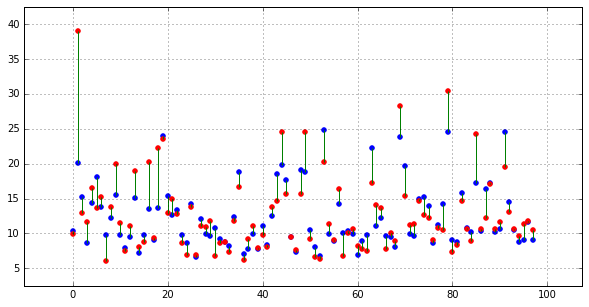

In [226]:
score_model('Lasso', X_train, y_train, X_test, target_not_normalized, best_alpha_lasso, None)

Cross validaton for  EN
BEST ALPHA (R2) =  0.0007  R2:  0.617006304857
BEST L1 (R2) =  0.0001  R2:  0.617006304857


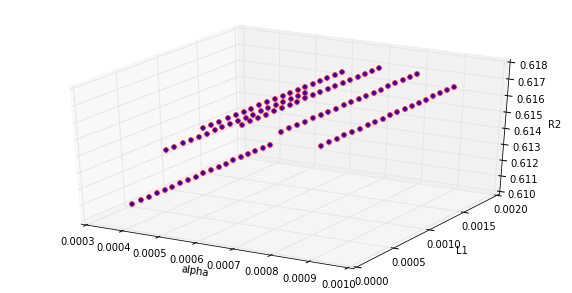

In [245]:
from sklearn.cross_validation import StratifiedKFold
n_folds=8
set_of_l1_ratios = np.arange(0.0001, 0.002, step=0.0001)
set_of_alpha = np.arange(0.0004, 0.001, step=0.0001)
best_params = cross_validation('EN', set_of_alpha, set_of_l1_ratios, X_train, y_train)
best_alpha_en = best_params[1]
best_L1_en = best_params[0]

BEST ALPHA (R2) = 0.0007
BEST L1 (R2) = 0.0001
R2 = 0.645817360116


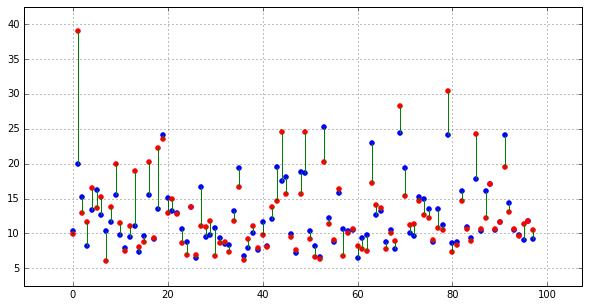

In [246]:
score_model('EN', X_train, y_train, X_test, target_not_normalized, best_alpha_en, best_L1_en)

In [247]:
lasso_best_alpha = linear_model.Lasso(alpha = best_alpha_lasso)
lasso_best_alpha.fit(X_train, y_train)
print "There are " ,(np.abs(lasso_best_alpha.coef_) < 0.1).sum(), " features to be taken out of ", lasso_best_alpha.coef_.shape[0], " available."

There are  135  features to be taken out of  243  available.


In [248]:
X_train_fs = X_train[:,np.abs(lasso_best_alpha.coef_) > 0.1]
X_test_fs = X_test[:,np.abs(lasso_best_alpha.coef_) > 0.1]
print X_test_fs.shape

(98, 108)


Cross validaton for  Ridge
BEST ALPHA (R2) =  0.0017  R2:  0.770950376574


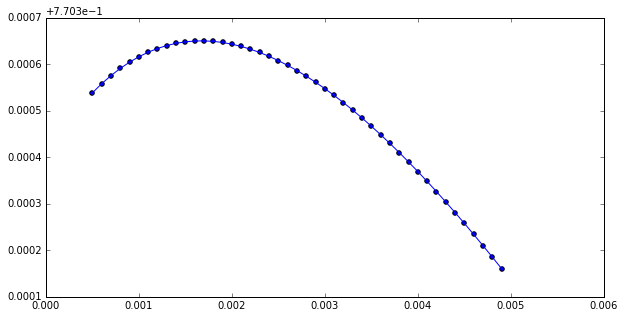

In [276]:
set_of_alphas = np.arange(0.0005, 0.005, step=0.0001)
best_alpha_ridge_fs = cross_validation('Ridge', set_of_alphas, None, X_train_fs, y_train)

BEST ALPHA (R2) = 0.0017
R2 = 0.644281197692


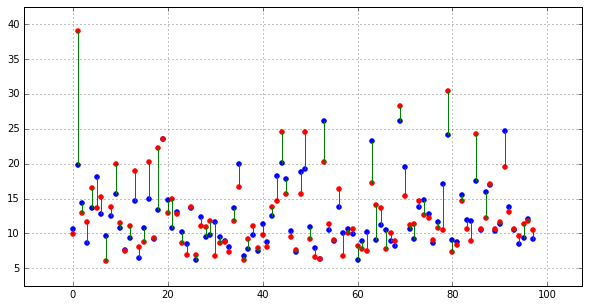

In [277]:
score_model('Ridge', X_train_fs, y_train, X_test_fs, target_not_normalized, best_alpha_ridge_fs, None)

Cross validaton for  Lasso
BEST ALPHA (R2) =  2.5e-06  R2:  0.770735135674


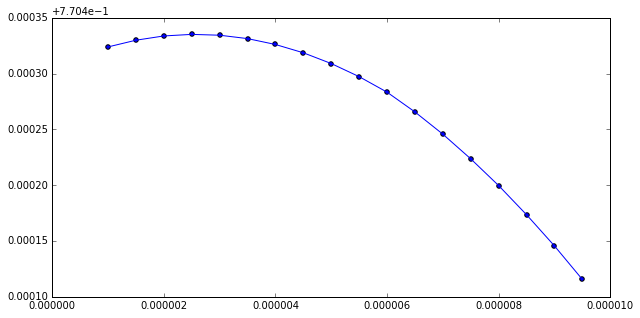

In [281]:
set_of_alphas = np.arange(0.000001, 0.00001, step=0.0000005)
best_alpha_lasso_fs = cross_validation('Lasso', set_of_alphas, None, X_train_fs, y_train)

BEST ALPHA (R2) = 2.5e-06
R2 = 0.6442592797


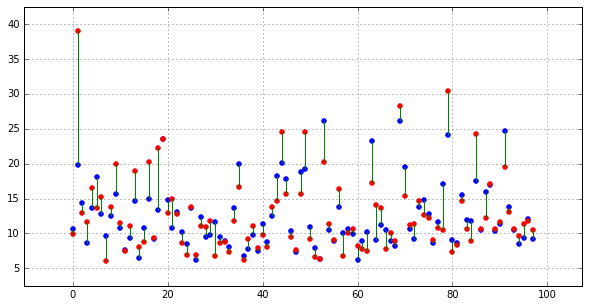

In [282]:
score_model('Lasso', X_train_fs, y_train, X_test_fs, target_not_normalized, best_alpha_lasso_fs, None)

In [354]:
data_3 = get_object_storage_file_with_credentials_a860223228054eadb78455bad5266913('ITTProject', 'Ridge.pkl')
fi = pickle.loads(codecs.decode(data_3.getvalue().encode(), "base64"))
print fi, type(fi)

Ridge(alpha=0.35000000000000014, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001) <class 'sklearn.linear_model.ridge.Ridge'>


In [355]:
fi.predict(X_train[0,:])

/usr/local/src/bluemix_jupyter_bundle.v43/notebook/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([ 0.45755828])